## summary

* 2.5d segmentation
    *  segmentation_models_pytorch 
    *  Unet
* use only 6 slices in the middle
* slide inference

In [1]:
# !pip install -q ../input/pytorch-segmentation-models-lib/pretrainedmodels-0.7.4/pretrainedmodels-0.7.4
# !pip install -q ../input/pytorch-segmentation-models-lib/efficientnet_pytorch-0.6.3/efficientnet_pytorch-0.6.3
# !pip install -q ../input/pytorch-segmentation-models-lib/timm-0.4.12-py3-none-any.whl
# !pip install -q ../input/pytorch-segmentation-models-lib/segmentation_models_pytorch-0.2.0-py3-none-any.whl

In [2]:
# !mkdir -p /root/.cache/torch/hub/checkpoints/
# !cp ../input/efficientnet-b0-355c32eb.pth /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth

In [3]:
# !pip install torch==1.10.2+cu113 torchvision==0.11.3+cu113 torchaudio===0.10.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

In [4]:

from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, log_loss
import pickle
from torch.utils.data import DataLoader
from torch.cuda.amp import autocast, GradScaler
import warnings
import sys
import pandas as pd
import os
import gc
import sys
import math
import time
import random
import shutil
from pathlib import Path
from contextlib import contextmanager
from collections import defaultdict, Counter
import cv2

import scipy as sp
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from functools import partial

import argparse
import importlib
import torch
import torch.nn as nn
from torch.optim import Adam, SGD, AdamW

import datetime

In [5]:
# sys.path.append('/kaggle/input/pretrainedmodels/pretrainedmodels-0.7.4')
# sys.path.append('/kaggle/input/efficientnet-pytorch/EfficientNet-PyTorch-master')
# sys.path.append('/kaggle/input/timm-pytorch-image-models/pytorch-image-models-master')
# sys.path.append('/kaggle/input/segmentation-models-pytorch/segmentation_models.pytorch-master')

In [6]:
import segmentation_models_pytorch as smp

In [7]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

## config

In [8]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2

class CFG:
    # ============== comp exp name =============
    comp_name = 'vesuvius'

    # comp_dir_path = './'
    comp_dir_path = '../input/'
    comp_folder_name = 'vesuvius-challenge-ink-detection'
    # comp_dataset_path = f'{comp_dir_path}datasets/{comp_folder_name}/'
    comp_dataset_path = f'{comp_dir_path}{comp_folder_name}/'
    
    exp_name = 'resnet-exp016'#'vesuvius_2d_slide_exp002'

    # ============== pred target =============
    target_size = 1

    # ============== model cfg =============
    model_name = 'Unet'
    # backbone = 'efficientnet-b0'
    # backbone = 'se_resnext50_32x4d'
    backbone = 'se_resnext101_32x4d'

    in_chans = 6 # 65
    # ============== training cfg =============
    size = 448 #224
    tile_size = 448 #224
    stride = tile_size // 2

    train_batch_size = 16 # 32
    valid_batch_size = train_batch_size * 2
    use_amp = True

    scheduler = 'GradualWarmupSchedulerV2'
    # scheduler = 'CosineAnnealingLR'
    epochs = 30 # 15

    # adamW warmupあり
    warmup_factor = 10
    # lr = 1e-4 / warmup_factor
    lr = 1e-4 / warmup_factor

    # ============== fold =============
    valid_id = 3 #1

    # objective_cv = 'binary'  # 'binary', 'multiclass', 'regression'
    metric_direction = 'maximize'  # maximize, 'minimize'
    # metrics = 'dice_coef'

    # ============== fixed =============
    pretrained = True
    inf_weight = 'best'  # 'best'

    min_lr = 1e-6
    weight_decay = 1e-6
    max_grad_norm = 1000

    print_freq = 50
    num_workers = 4

    seed = 42

    # ============== set dataset path =============
    print('set dataset path')

    outputs_path = f'../output/{comp_name}/{exp_name}/'

    submission_dir = outputs_path + 'submissions/'
    submission_path = submission_dir + f'submission_{exp_name}.csv'

    model_dir = outputs_path + \
        f'{comp_name}-models/'

    figures_dir = outputs_path + 'figures/'

    log_dir = outputs_path + 'logs/'
    log_path = log_dir + f'{exp_name}.txt'

    # ============== augmentation =============
    train_aug_list = [
        # A.RandomResizedCrop(
        #     size, size, scale=(0.85, 1.0)),
        A.Resize(size, size),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.75),
        A.ShiftScaleRotate(p=0.75),
        A.OneOf([
                A.GaussNoise(var_limit=[10, 50]),
                A.GaussianBlur(),
                A.MotionBlur(),
                ], p=0.4),
        A.GridDistortion(num_steps=5, distort_limit=0.3, p=0.5),
        A.CoarseDropout(max_holes=1, max_width=int(size * 0.3), max_height=int(size * 0.3), 
                        mask_fill_value=0, p=0.5),
        # A.Cutout(max_h_size=int(size * 0.6),
        #          max_w_size=int(size * 0.6), num_holes=1, p=1.0),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]

    valid_aug_list = [
        A.Resize(size, size),
        A.Normalize(
            mean= [0] * in_chans,
            std= [1] * in_chans
        ),
        ToTensorV2(transpose_mask=True),
    ]


set dataset path


## helper

In [9]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
def init_logger(log_file):
    from logging import getLogger, INFO, FileHandler, Formatter, StreamHandler
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=log_file)
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

def set_seed(seed=None, cudnn_deterministic=True):
    if seed is None:
        seed = 42

    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = cudnn_deterministic
    torch.backends.cudnn.benchmark = False

In [11]:
def make_dirs(cfg):
    for dir in [cfg.model_dir, cfg.figures_dir, cfg.submission_dir, cfg.log_dir]:
        os.makedirs(dir, exist_ok=True)

In [12]:
def cfg_init(cfg, mode='train'):
    set_seed(cfg.seed)
    # set_env_name()
    # set_dataset_path(cfg)

    if mode == 'train':
        make_dirs(cfg)

In [13]:
cfg_init(CFG)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Logger = init_logger(log_file=CFG.log_path)

Logger.info('\n\n-------- exp_info -----------------')
# Logger.info(datetime.datetime.now().strftime('%Y年%m月%d日 %H:%M:%S'))



-------- exp_info -----------------


## image, mask

In [14]:
def read_image_mask(fragment_id):

    images = []

    # idxs = range(65)
    mid = 65 // 2
    start = mid - CFG.in_chans // 2
    end = mid + CFG.in_chans // 2
    idxs = range(start, end)

    for i in tqdm(idxs):
        
        image = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/surface_volume/{i:02}.tif", 0)

        pad0 = (CFG.tile_size - image.shape[0] % CFG.tile_size)
        pad1 = (CFG.tile_size - image.shape[1] % CFG.tile_size)

        image = np.pad(image, [(0, pad0), (0, pad1)], constant_values=0)

        images.append(image)
    images = np.stack(images, axis=2)

    mask = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
    mask = np.pad(mask, [(0, pad0), (0, pad1)], constant_values=0)

    mask = mask.astype('float32')
    mask /= 255.0
    
    return images, mask

In [15]:
def get_train_valid_dataset():
    train_images = []
    train_masks = []

    valid_images = []
    valid_masks = []
    valid_xyxys = []

    for fragment_id in range(1, 4):

        image, mask = read_image_mask(fragment_id)

        x1_list = list(range(0, image.shape[1]-CFG.tile_size+1, CFG.stride))
        y1_list = list(range(0, image.shape[0]-CFG.tile_size+1, CFG.stride))

        for y1 in y1_list:
            for x1 in x1_list:
                y2 = y1 + CFG.tile_size
                x2 = x1 + CFG.tile_size
                # xyxys.append((x1, y1, x2, y2))
        
                if fragment_id == CFG.valid_id:
                    valid_images.append(image[y1:y2, x1:x2])
                    valid_masks.append(mask[y1:y2, x1:x2, None])

                    valid_xyxys.append([x1, y1, x2, y2])
                else:
                    train_images.append(image[y1:y2, x1:x2])
                    train_masks.append(mask[y1:y2, x1:x2, None])

    return train_images, train_masks, valid_images, valid_masks, valid_xyxys

In [16]:
train_images, train_masks, valid_images, valid_masks, valid_xyxys = get_train_valid_dataset()

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
# valid_xyxys = np.stack(valid_xyxys)

## dataset

In [18]:
import numpy as np
from torch.utils.data import DataLoader, Dataset
import cv2
import torch
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from albumentations import ImageOnlyTransform

In [19]:
def get_transforms(data, cfg):
    if data == 'train':
        aug = A.Compose(cfg.train_aug_list)
    elif data == 'valid':
        aug = A.Compose(cfg.valid_aug_list)

    # print(aug)
    return aug

class CustomDataset(Dataset):
    def __init__(self, images, cfg, labels=None, transform=None):
        self.images = images
        self.cfg = cfg
        self.labels = labels
        self.transform = transform

    def __len__(self):
        # return len(self.df)
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        if self.transform:
            data = self.transform(image=image, mask=label)
            image = data['image']
            label = data['mask']

        return image, label

In [20]:

train_dataset = CustomDataset(
    train_images, CFG, labels=train_masks, transform=get_transforms(data='train', cfg=CFG))
valid_dataset = CustomDataset(
    valid_images, CFG, labels=valid_masks, transform=get_transforms(data='valid', cfg=CFG))

train_loader = DataLoader(train_dataset,
                          batch_size=CFG.train_batch_size,
                          shuffle=True,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=True,
                          )
valid_loader = DataLoader(valid_dataset,
                          batch_size=CFG.valid_batch_size,
                          shuffle=False,
                          num_workers=CFG.num_workers, pin_memory=True, drop_last=False)


In [21]:
train_dataset[0][0].shape

torch.Size([6, 448, 448])

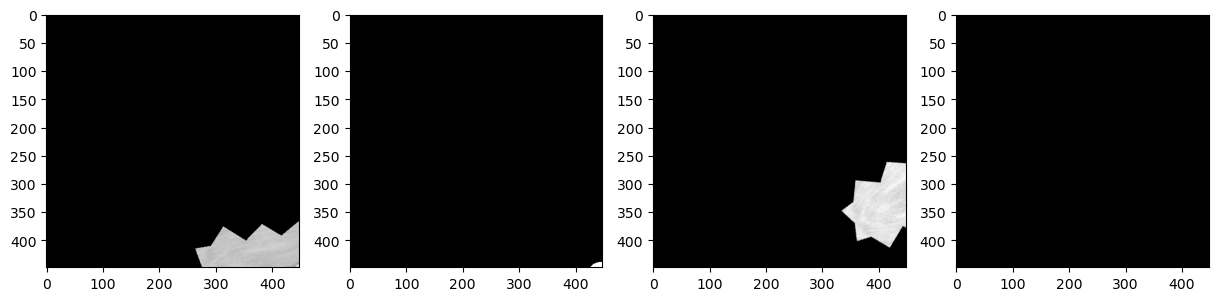

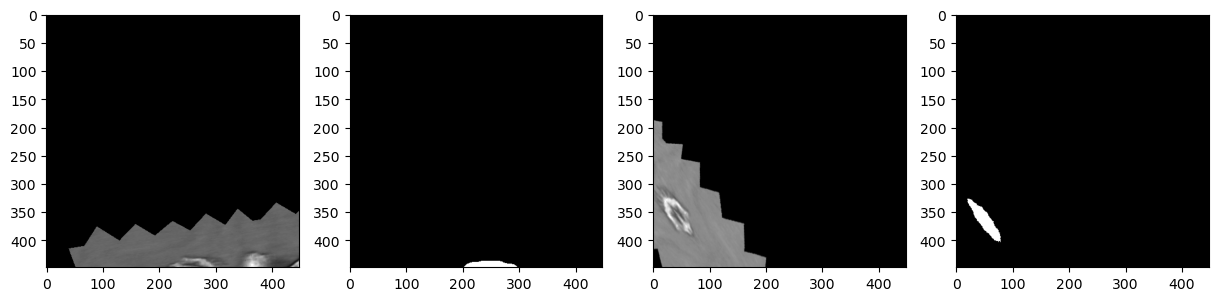

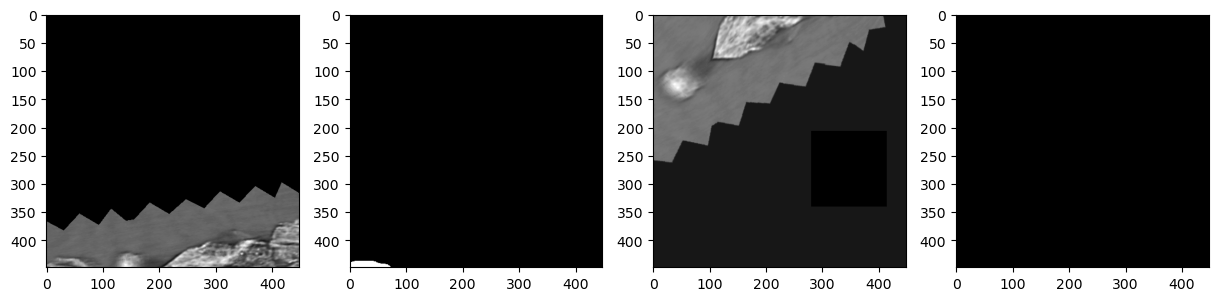

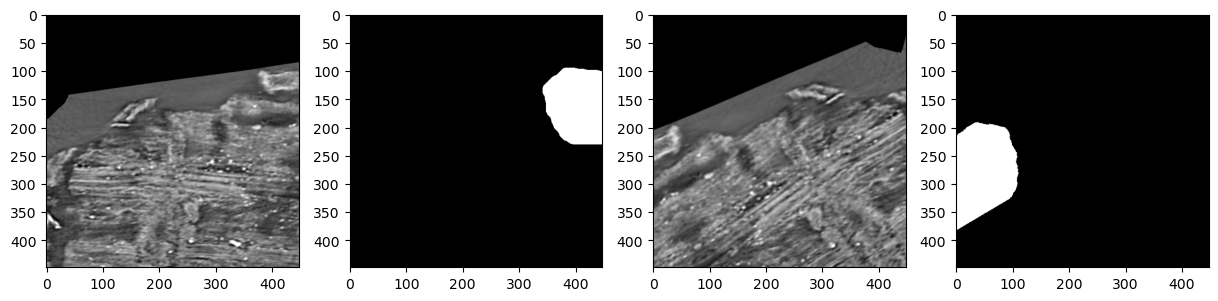

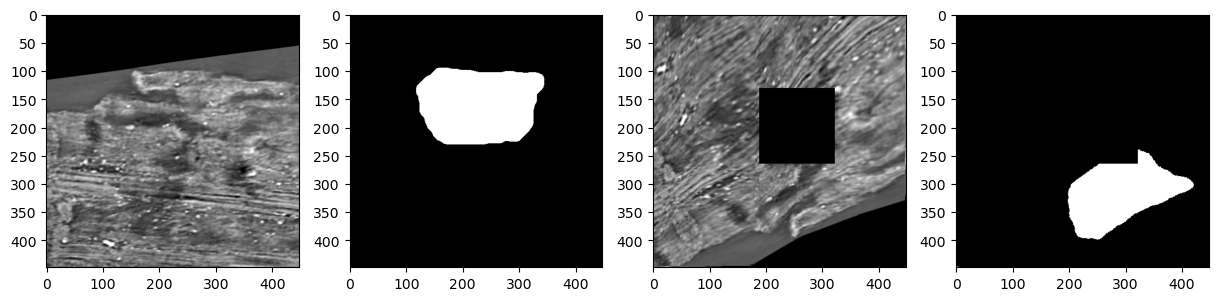

In [22]:

plot_dataset = CustomDataset(
    train_images, CFG, labels=train_masks)

transform = CFG.train_aug_list
transform = A.Compose(
    [t for t in transform if not isinstance(t, (A.Normalize, ToTensorV2))])


plot_count = 0
for i in range(1000):

    image, mask = plot_dataset[i]
    data = transform(image=image, mask=mask)
    aug_image = data['image']
    aug_mask = data['mask']

    if mask.sum() == 0:
        continue

    fig, axes = plt.subplots(1, 4, figsize=(15, 8))
    axes[0].imshow(image[..., 0], cmap="gray")
    axes[1].imshow(mask, cmap="gray")
    axes[2].imshow(aug_image[..., 0], cmap="gray")
    axes[3].imshow(aug_mask, cmap="gray")
    
    plt.savefig(CFG.figures_dir + f'aug_fold_{CFG.valid_id}_{plot_count}.png')

    plot_count += 1
    if plot_count == 5:
        break

In [23]:
del plot_dataset
gc.collect()

48110

## model

In [24]:
class CustomModel(nn.Module):
    def __init__(self, cfg, weight=None):
        super().__init__()
        self.cfg = cfg

        self.encoder = smp.Unet(
            encoder_name=cfg.backbone, 
            encoder_weights=weight,
            in_channels=cfg.in_chans,
            classes=cfg.target_size,
            activation=None,
        )

    def forward(self, image):
        output = self.encoder(image)
        # output = output.squeeze(-1)
        return output


def build_model(cfg, weight="imagenet"):
    print('model_name', cfg.model_name)
    print('backbone', cfg.backbone)

    model = CustomModel(cfg, weight)

    return model

In [25]:
# def build_model():
#     model = smp.Unet(
#         encoder_name=CFG.backbone,      # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
#         encoder_weights=None,     # use `imagenet` pre-trained weights for encoder initialization
#         in_channels=CFG.in_chans,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
#         classes=CFG.target_size,        # model output channels (number of classes in your dataset)
#         activation=None,
#     )
#     model.to(CFG.device)
#     return model

# def load_model(path):
#     model = build_model()
#     model.load_state_dict(torch.load(path))
#     model.eval()
#     return model

## scheduler

In [26]:

import torch.nn as nn
import torch
import math
import time
import numpy as np
import torch

from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, CosineAnnealingLR, ReduceLROnPlateau
from warmup_scheduler import GradualWarmupScheduler


class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    """
    https://www.kaggle.com/code/underwearfitting/single-fold-training-of-resnet200d-lb0-965
    """
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(
            optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [
                        base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

def get_scheduler(cfg, optimizer):
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingLR(
        optimizer, cfg.epochs, eta_min=1e-7)
    scheduler = GradualWarmupSchedulerV2(
        optimizer, multiplier=10, total_epoch=1, after_scheduler=scheduler_cosine)

    return scheduler

def scheduler_step(scheduler, avg_val_loss, epoch):
    scheduler.step(epoch)


In [27]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [28]:
model = build_model(CFG)
model.to(device)

optimizer = AdamW(model.parameters(), lr=CFG.lr)
scheduler = get_scheduler(CFG, optimizer)

model_name Unet
backbone se_resnext101_32x4d


## loss

In [29]:

DiceLoss = smp.losses.DiceLoss(mode='binary')
BCELoss = smp.losses.SoftBCEWithLogitsLoss()

alpha = 0.5
beta = 1 - alpha
TverskyLoss = smp.losses.TverskyLoss(
    mode='binary', log_loss=False, alpha=alpha, beta=beta)

def criterion(y_pred, y_true):
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * DiceLoss(y_pred, y_true)
    return BCELoss(y_pred, y_true)
    # return 0.5 * BCELoss(y_pred, y_true) + 0.5 * TverskyLoss(y_pred, y_true)

## train, val

In [30]:
def train_fn(train_loader, model, criterion, optimizer, device):
    model.train()

    scaler = GradScaler(enabled=CFG.use_amp)
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(train_loader), total=len(train_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with autocast(CFG.use_amp):
            y_preds = model(images)
            loss = criterion(y_preds, labels)

        losses.update(loss.item(), batch_size)
        scaler.scale(loss).backward()

        grad_norm = torch.nn.utils.clip_grad_norm_(
            model.parameters(), CFG.max_grad_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

    return losses.avg

def valid_fn(valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt):
    mask_pred = np.zeros(valid_mask_gt.shape)
    mask_count = np.zeros(valid_mask_gt.shape)

    model.eval()
    losses = AverageMeter()

    for step, (images, labels) in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        images = images.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)

        with torch.no_grad():
            y_preds = model(images)
            loss = criterion(y_preds, labels)
        losses.update(loss.item(), batch_size)

        # make whole mask
        y_preds = torch.sigmoid(y_preds).to('cpu').numpy()
        start_idx = step*CFG.valid_batch_size
        end_idx = start_idx + batch_size
        for i, (x1, y1, x2, y2) in enumerate(valid_xyxys[start_idx:end_idx]):
            mask_pred[y1:y2, x1:x2] += y_preds[i].squeeze(0)
            mask_count[y1:y2, x1:x2] += np.ones((CFG.tile_size, CFG.tile_size))

    print(f'mask_count_min: {mask_count.min()}')
    mask_pred /= mask_count
    return losses.avg, mask_pred

## metrics

In [31]:
from sklearn.metrics import fbeta_score

def fbeta_numpy(targets, preds, beta=0.5, smooth=1e-5):
    """
    https://www.kaggle.com/competitions/vesuvius-challenge-ink-detection/discussion/397288
    """
    y_true_count = targets.sum()
    ctp = preds[targets==1].sum()
    cfp = preds[targets==0].sum()
    beta_squared = beta * beta

    c_precision = ctp / (ctp + cfp + smooth)
    c_recall = ctp / (y_true_count + smooth)
    dice = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall + smooth)

    return dice

def calc_fbeta(mask, mask_pred):
    mask = mask.astype(int).flatten()
    mask_pred = mask_pred.flatten()

    best_th = 0
    best_dice = 0
    for th in np.array(range(10, 50+1, 5)) / 100:
        
        # dice = fbeta_score(mask, (mask_pred >= th).astype(int), beta=0.5)
        dice = fbeta_numpy(mask, (mask_pred >= th).astype(int), beta=0.5)
        print(f'th: {th}, fbeta: {dice}')

        if dice > best_dice:
            best_dice = dice
            best_th = th
    
    Logger.info(f'best_th: {best_th}, fbeta: {best_dice}')
    return best_dice, best_th


def calc_cv(mask_gt, mask_pred):
    best_dice, best_th = calc_fbeta(mask_gt, mask_pred)

    return best_dice, best_th

## main

In [32]:
fragment_id = CFG.valid_id

valid_mask_gt = cv2.imread(CFG.comp_dataset_path + f"train/{fragment_id}/inklabels.png", 0)
valid_mask_gt = valid_mask_gt / 255
pad0 = (CFG.tile_size - valid_mask_gt.shape[0] % CFG.tile_size)
pad1 = (CFG.tile_size - valid_mask_gt.shape[1] % CFG.tile_size)
valid_mask_gt = np.pad(valid_mask_gt, [(0, pad0), (0, pad1)], constant_values=0)

In [33]:

fold = CFG.valid_id

if CFG.metric_direction == 'minimize':
    best_score = np.inf
elif CFG.metric_direction == 'maximize':
    best_score = -1

best_loss = np.inf

for epoch in range(CFG.epochs):

    start_time = time.time()

    # train
    avg_loss = train_fn(train_loader, model, criterion, optimizer, device)

    # eval
    avg_val_loss, mask_pred = valid_fn(
        valid_loader, model, criterion, device, valid_xyxys, valid_mask_gt)

    scheduler_step(scheduler, avg_val_loss, epoch)

    best_dice, best_th = calc_cv(valid_mask_gt, mask_pred)

    # score = avg_val_loss
    score = best_dice

    elapsed = time.time() - start_time

    Logger.info(
        f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
    # Logger.info(f'Epoch {epoch+1} - avgScore: {avg_score:.4f}')
    Logger.info(
        f'Epoch {epoch+1} - avgScore: {score:.4f}')

    if CFG.metric_direction == 'minimize':
        update_best = score < best_score
    elif CFG.metric_direction == 'maximize':
        update_best = score > best_score

    if update_best:
        best_loss = avg_val_loss
        best_score = score

        Logger.info(
            f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
        Logger.info(
            f'Epoch {epoch+1} - Save Best Loss: {best_loss:.4f} Model')
        
        torch.save({'model': model.state_dict(),
                    'preds': mask_pred},
                    CFG.model_dir + f'{CFG.model_name}_fold{fold}_best.pth')

  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


th: 0.1, fbeta: 0.09907762713323046
th: 0.15, fbeta: 0.14958396812557198
th: 0.2, fbeta: 0.16057191416083805
th: 0.25, fbeta: 0.16903561862589367
th: 0.3, fbeta: 0.17855720635480926
th: 0.35, fbeta: 0.19143778047818824
th: 0.4, fbeta: 0.20817342100448083
th: 0.45, fbeta: 0.22810721927542985


best_th: 0.5, fbeta: 0.24784882182522172
Epoch 1 - avg_train_loss: 0.4714  avg_val_loss: 0.3997  time: 176s
Epoch 1 - avgScore: 0.2478
Epoch 1 - Save Best Score: 0.2478 Model
Epoch 1 - Save Best Loss: 0.3997 Model


th: 0.5, fbeta: 0.24784882182522172


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.09708003429313862
th: 0.15, fbeta: 0.15883297199702123
th: 0.2, fbeta: 0.1815858818104123
th: 0.25, fbeta: 0.20398296159389473
th: 0.3, fbeta: 0.23121082348394215
th: 0.35, fbeta: 0.2656196547602138
th: 0.4, fbeta: 0.30771503397507965
th: 0.45, fbeta: 0.35183504004050126


best_th: 0.5, fbeta: 0.3887215827481616
Epoch 2 - avg_train_loss: 0.3836  avg_val_loss: 0.3529  time: 178s
Epoch 2 - avgScore: 0.3887
Epoch 2 - Save Best Score: 0.3887 Model
Epoch 2 - Save Best Loss: 0.3529 Model


th: 0.5, fbeta: 0.3887215827481616


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0


/opt/conda/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:715: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


th: 0.1, fbeta: 0.1861567619295479
th: 0.15, fbeta: 0.21688935765765696
th: 0.2, fbeta: 0.2508713414238224
th: 0.25, fbeta: 0.29086291037077705
th: 0.3, fbeta: 0.3310801691946254
th: 0.35, fbeta: 0.37067303962758474
th: 0.4, fbeta: 0.40821574994470206
th: 0.45, fbeta: 0.4433331551032822


best_th: 0.5, fbeta: 0.4736842687177935
Epoch 3 - avg_train_loss: 0.2865  avg_val_loss: 0.2521  time: 178s
Epoch 3 - avgScore: 0.4737
Epoch 3 - Save Best Score: 0.4737 Model
Epoch 3 - Save Best Loss: 0.2521 Model


th: 0.5, fbeta: 0.4736842687177935


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.22920857358930607
th: 0.15, fbeta: 0.276969512897132
th: 0.2, fbeta: 0.3200598480513733
th: 0.25, fbeta: 0.35674575157645416
th: 0.3, fbeta: 0.38793082008575863
th: 0.35, fbeta: 0.41704250266814835
th: 0.4, fbeta: 0.4450141294381958
th: 0.45, fbeta: 0.47304781792520345


best_th: 0.5, fbeta: 0.49568234794408583
Epoch 4 - avg_train_loss: 0.2262  avg_val_loss: 0.2184  time: 178s
Epoch 4 - avgScore: 0.4957
Epoch 4 - Save Best Score: 0.4957 Model
Epoch 4 - Save Best Loss: 0.2184 Model


th: 0.5, fbeta: 0.49568234794408583


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2382897698518479
th: 0.15, fbeta: 0.2677201210512086
th: 0.2, fbeta: 0.29545407876911983
th: 0.25, fbeta: 0.3229813710988057
th: 0.3, fbeta: 0.3517842002308896
th: 0.35, fbeta: 0.3804103262544163
th: 0.4, fbeta: 0.4100372243693725
th: 0.45, fbeta: 0.4382224630778264


best_th: 0.5, fbeta: 0.4645547732348283
Epoch 5 - avg_train_loss: 0.2030  avg_val_loss: 0.2368  time: 179s
Epoch 5 - avgScore: 0.4646


th: 0.5, fbeta: 0.4645547732348283


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2782436683527128
th: 0.15, fbeta: 0.30464559389491763
th: 0.2, fbeta: 0.3289229681349842
th: 0.25, fbeta: 0.35309071994903635
th: 0.3, fbeta: 0.37751934097836254
th: 0.35, fbeta: 0.4010199434679921
th: 0.4, fbeta: 0.42102317810303647
th: 0.45, fbeta: 0.43881916467309745


best_th: 0.5, fbeta: 0.45678225648627135
Epoch 6 - avg_train_loss: 0.1830  avg_val_loss: 0.2352  time: 179s
Epoch 6 - avgScore: 0.4568


th: 0.5, fbeta: 0.45678225648627135


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23564857987005322
th: 0.15, fbeta: 0.25722500232106
th: 0.2, fbeta: 0.2759836782655318
th: 0.25, fbeta: 0.29321360145586417
th: 0.3, fbeta: 0.31047388884146526
th: 0.35, fbeta: 0.3290279381589873
th: 0.4, fbeta: 0.35034741220732996
th: 0.45, fbeta: 0.37104883039710335


best_th: 0.5, fbeta: 0.3935268117027862
Epoch 7 - avg_train_loss: 0.1660  avg_val_loss: 0.2723  time: 179s
Epoch 7 - avgScore: 0.3935


th: 0.5, fbeta: 0.3935268117027862


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.37913678529124606
th: 0.15, fbeta: 0.4347182738567264
th: 0.2, fbeta: 0.47682746902338236
th: 0.25, fbeta: 0.5100592327182137
th: 0.3, fbeta: 0.5352963859853425
th: 0.35, fbeta: 0.553700805484046
th: 0.4, fbeta: 0.5604752462484427


best_th: 0.45, fbeta: 0.5612338221940055
Epoch 8 - avg_train_loss: 0.1511  avg_val_loss: 0.2064  time: 178s
Epoch 8 - avgScore: 0.5612
Epoch 8 - Save Best Score: 0.5612 Model
Epoch 8 - Save Best Loss: 0.2064 Model


th: 0.45, fbeta: 0.5612338221940055
th: 0.5, fbeta: 0.558856884428535


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.23839961709835833
th: 0.15, fbeta: 0.2568337706071042
th: 0.2, fbeta: 0.27360459959892985
th: 0.25, fbeta: 0.28896344683036274
th: 0.3, fbeta: 0.30358059047166663
th: 0.35, fbeta: 0.31804187469729545
th: 0.4, fbeta: 0.33397445664686104
th: 0.45, fbeta: 0.3502180613398309


best_th: 0.5, fbeta: 0.3670850053600112
Epoch 9 - avg_train_loss: 0.1415  avg_val_loss: 0.3132  time: 179s
Epoch 9 - avgScore: 0.3671


th: 0.5, fbeta: 0.3670850053600112


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.2946144297159068
th: 0.15, fbeta: 0.32148407445523136
th: 0.2, fbeta: 0.3454487129316432
th: 0.25, fbeta: 0.3670326028980089
th: 0.3, fbeta: 0.3875815015847253
th: 0.35, fbeta: 0.40746068966087945
th: 0.4, fbeta: 0.42617738394352406
th: 0.45, fbeta: 0.4427937400769134


best_th: 0.5, fbeta: 0.45818471897186813
Epoch 10 - avg_train_loss: 0.1326  avg_val_loss: 0.2416  time: 179s
Epoch 10 - avgScore: 0.4582


th: 0.5, fbeta: 0.45818471897186813


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39450135620399374
th: 0.15, fbeta: 0.4345601116165946
th: 0.2, fbeta: 0.4660896797978945
th: 0.25, fbeta: 0.4898813191291477
th: 0.3, fbeta: 0.510173779464412
th: 0.35, fbeta: 0.5283652842529492
th: 0.4, fbeta: 0.543062796517404
th: 0.45, fbeta: 0.5565761998118705


best_th: 0.5, fbeta: 0.5666179815872391
Epoch 11 - avg_train_loss: 0.1214  avg_val_loss: 0.2169  time: 179s
Epoch 11 - avgScore: 0.5666
Epoch 11 - Save Best Score: 0.5666 Model
Epoch 11 - Save Best Loss: 0.2169 Model


th: 0.5, fbeta: 0.5666179815872391


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.30342775575433767
th: 0.15, fbeta: 0.32396599566055845
th: 0.2, fbeta: 0.34025079244265216
th: 0.25, fbeta: 0.35557114619877705
th: 0.3, fbeta: 0.3701845840019131
th: 0.35, fbeta: 0.38648792231971074
th: 0.4, fbeta: 0.403901799217859
th: 0.45, fbeta: 0.42101901445642304


best_th: 0.5, fbeta: 0.4381221160369643
Epoch 12 - avg_train_loss: 0.1115  avg_val_loss: 0.2703  time: 179s
Epoch 12 - avgScore: 0.4381


th: 0.5, fbeta: 0.4381221160369643


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3436944348273801
th: 0.15, fbeta: 0.37655316272605704
th: 0.2, fbeta: 0.4047419276714102
th: 0.25, fbeta: 0.4316165150270058
th: 0.3, fbeta: 0.45733544434821705
th: 0.35, fbeta: 0.48165291274535554
th: 0.4, fbeta: 0.5034431938312827


best_th: 0.5, fbeta: 0.5368176758341876
Epoch 13 - avg_train_loss: 0.1016  avg_val_loss: 0.2114  time: 180s
Epoch 13 - avgScore: 0.5368


th: 0.45, fbeta: 0.5213835427324999
th: 0.5, fbeta: 0.5368176758341876


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3663827624111912
th: 0.15, fbeta: 0.4024665351996505
th: 0.2, fbeta: 0.43022202704192
th: 0.25, fbeta: 0.45321698528940063
th: 0.3, fbeta: 0.4722898994315354
th: 0.35, fbeta: 0.48937604261332224
th: 0.4, fbeta: 0.5052107443438206
th: 0.45, fbeta: 0.5193751924432823


best_th: 0.5, fbeta: 0.5321971527123273
Epoch 14 - avg_train_loss: 0.0974  avg_val_loss: 0.2173  time: 179s
Epoch 14 - avgScore: 0.5322


th: 0.5, fbeta: 0.5321971527123273


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33321315954612835
th: 0.15, fbeta: 0.35957656787990494
th: 0.2, fbeta: 0.38192920458608215
th: 0.25, fbeta: 0.40210307009868956
th: 0.3, fbeta: 0.4193240927834742
th: 0.35, fbeta: 0.43622160356754325
th: 0.4, fbeta: 0.4537863335537361
th: 0.45, fbeta: 0.46991269868116453


best_th: 0.5, fbeta: 0.4854898749196106
Epoch 15 - avg_train_loss: 0.0910  avg_val_loss: 0.2537  time: 178s
Epoch 15 - avgScore: 0.4855


th: 0.5, fbeta: 0.4854898749196106


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.39579558123586694
th: 0.15, fbeta: 0.4268568761114342
th: 0.2, fbeta: 0.4532545563480528
th: 0.25, fbeta: 0.4757865459008476
th: 0.3, fbeta: 0.49588845655200975
th: 0.35, fbeta: 0.5132101581341573
th: 0.4, fbeta: 0.5298524994516292
th: 0.45, fbeta: 0.5441657701651994
th: 0.5, fbeta: 0.555007617142365


best_th: 0.5, fbeta: 0.555007617142365
Epoch 16 - avg_train_loss: 0.0848  avg_val_loss: 0.2190  time: 177s
Epoch 16 - avgScore: 0.5550


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3634249995316037
th: 0.15, fbeta: 0.39335766204713707
th: 0.2, fbeta: 0.4206494220946663
th: 0.25, fbeta: 0.44313772818825437
th: 0.3, fbeta: 0.4617774102538949
th: 0.35, fbeta: 0.47963792790796184
th: 0.4, fbeta: 0.4957575210521954
th: 0.45, fbeta: 0.5092366608271691


best_th: 0.5, fbeta: 0.5202588482423967
Epoch 17 - avg_train_loss: 0.0802  avg_val_loss: 0.2472  time: 178s
Epoch 17 - avgScore: 0.5203


th: 0.5, fbeta: 0.5202588482423967


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3978119168602975
th: 0.15, fbeta: 0.4296095523225428
th: 0.2, fbeta: 0.4551130108563221
th: 0.25, fbeta: 0.4763542743432599
th: 0.3, fbeta: 0.4932592321809887
th: 0.35, fbeta: 0.5059287959595078
th: 0.4, fbeta: 0.517806614735568
th: 0.45, fbeta: 0.5302404843154215


best_th: 0.5, fbeta: 0.5432361045535306
Epoch 18 - avg_train_loss: 0.0762  avg_val_loss: 0.2372  time: 178s
Epoch 18 - avgScore: 0.5432


th: 0.5, fbeta: 0.5432361045535306


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3933667310998645
th: 0.15, fbeta: 0.4304479460549019
th: 0.2, fbeta: 0.4600558770368572
th: 0.25, fbeta: 0.48170418575100216
th: 0.3, fbeta: 0.5008376827005809
th: 0.35, fbeta: 0.5168367291957084
th: 0.4, fbeta: 0.5284002537910709


best_th: 0.5, fbeta: 0.5416434248987597
Epoch 19 - avg_train_loss: 0.0697  avg_val_loss: 0.2463  time: 177s
Epoch 19 - avgScore: 0.5416


th: 0.45, fbeta: 0.5366001008407657
th: 0.5, fbeta: 0.5416434248987597


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.33640375864462746
th: 0.15, fbeta: 0.36388633764240486
th: 0.2, fbeta: 0.387190841827115
th: 0.25, fbeta: 0.4093995668332131
th: 0.3, fbeta: 0.4299764295731632
th: 0.35, fbeta: 0.4485773637883665
th: 0.4, fbeta: 0.46562368156622536
th: 0.45, fbeta: 0.48135288990091474


best_th: 0.5, fbeta: 0.4971667479429973
Epoch 20 - avg_train_loss: 0.0672  avg_val_loss: 0.2561  time: 176s
Epoch 20 - avgScore: 0.4972


th: 0.5, fbeta: 0.4971667479429973


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.34690662091165825
th: 0.15, fbeta: 0.377572546232975
th: 0.2, fbeta: 0.40249258945150246
th: 0.25, fbeta: 0.42657184079523075
th: 0.3, fbeta: 0.44899552592638975
th: 0.35, fbeta: 0.4687378329646989
th: 0.4, fbeta: 0.4858802832374676
th: 0.45, fbeta: 0.5019918189980958


best_th: 0.5, fbeta: 0.5157931273150022
Epoch 21 - avg_train_loss: 0.0653  avg_val_loss: 0.2474  time: 177s
Epoch 21 - avgScore: 0.5158


th: 0.5, fbeta: 0.5157931273150022


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3432920683599326
th: 0.15, fbeta: 0.374511505416687
th: 0.2, fbeta: 0.40042214011529775
th: 0.25, fbeta: 0.42407063257367
th: 0.3, fbeta: 0.4447994131764284
th: 0.35, fbeta: 0.46372708436276283
th: 0.4, fbeta: 0.480223186944369
th: 0.45, fbeta: 0.49515771784875395


best_th: 0.5, fbeta: 0.5082576623458115
Epoch 22 - avg_train_loss: 0.0617  avg_val_loss: 0.2564  time: 176s
Epoch 22 - avgScore: 0.5083


th: 0.5, fbeta: 0.5082576623458115


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4217965908810918
th: 0.15, fbeta: 0.4538124267754526
th: 0.2, fbeta: 0.47826510653672044
th: 0.25, fbeta: 0.49763659151566697
th: 0.3, fbeta: 0.5135963026674978
th: 0.35, fbeta: 0.5275046982160654
th: 0.4, fbeta: 0.5397383235095545
th: 0.45, fbeta: 0.5500812602009341


best_th: 0.5, fbeta: 0.5601793370670345
Epoch 23 - avg_train_loss: 0.0578  avg_val_loss: 0.2465  time: 177s
Epoch 23 - avgScore: 0.5602


th: 0.5, fbeta: 0.5601793370670345


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3995903399897017
th: 0.15, fbeta: 0.42734459962028304
th: 0.2, fbeta: 0.4535281663509865
th: 0.25, fbeta: 0.47627673019016525
th: 0.3, fbeta: 0.4961260821109346
th: 0.35, fbeta: 0.5113868981760176
th: 0.4, fbeta: 0.522516343780373
th: 0.45, fbeta: 0.5320550308379357


best_th: 0.5, fbeta: 0.5389558434344227
Epoch 24 - avg_train_loss: 0.0566  avg_val_loss: 0.2571  time: 176s
Epoch 24 - avgScore: 0.5390


th: 0.5, fbeta: 0.5389558434344227


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3839103263777006
th: 0.15, fbeta: 0.4123427743474372
th: 0.2, fbeta: 0.4371102751669708
th: 0.25, fbeta: 0.45908632911061503
th: 0.3, fbeta: 0.47811470260851113
th: 0.35, fbeta: 0.4941878875897158
th: 0.4, fbeta: 0.5071171521281032
th: 0.45, fbeta: 0.5189151906283777


best_th: 0.5, fbeta: 0.5288220087646989
Epoch 25 - avg_train_loss: 0.0540  avg_val_loss: 0.2559  time: 177s
Epoch 25 - avgScore: 0.5288


th: 0.5, fbeta: 0.5288220087646989


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3936507372389472
th: 0.15, fbeta: 0.4253773613718671
th: 0.2, fbeta: 0.4520183993589635
th: 0.25, fbeta: 0.4760482145238797
th: 0.3, fbeta: 0.49546562749487244
th: 0.35, fbeta: 0.5100463588956544
th: 0.4, fbeta: 0.5224895025921205
th: 0.45, fbeta: 0.5316955998165601


best_th: 0.5, fbeta: 0.5398306578459242
Epoch 26 - avg_train_loss: 0.0536  avg_val_loss: 0.2511  time: 177s
Epoch 26 - avgScore: 0.5398


th: 0.5, fbeta: 0.5398306578459242


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3954703161680358
th: 0.15, fbeta: 0.4282748721080352
th: 0.2, fbeta: 0.45649016363286254
th: 0.25, fbeta: 0.48076555953398
th: 0.3, fbeta: 0.4995889338493356
th: 0.35, fbeta: 0.5134770391035033
th: 0.4, fbeta: 0.5247979456804581
th: 0.45, fbeta: 0.5346426123612209


best_th: 0.5, fbeta: 0.5430047917936397
Epoch 27 - avg_train_loss: 0.0517  avg_val_loss: 0.2597  time: 177s
Epoch 27 - avgScore: 0.5430


th: 0.5, fbeta: 0.5430047917936397


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4018296249679092
th: 0.15, fbeta: 0.4325538558207239
th: 0.2, fbeta: 0.4574906453204647
th: 0.25, fbeta: 0.4797537117602178
th: 0.3, fbeta: 0.4983156550563546
th: 0.35, fbeta: 0.5130298079966789
th: 0.4, fbeta: 0.5252158698169599
th: 0.45, fbeta: 0.535059040360374


best_th: 0.5, fbeta: 0.544457536984578
Epoch 28 - avg_train_loss: 0.0504  avg_val_loss: 0.2695  time: 178s
Epoch 28 - avgScore: 0.5445


th: 0.5, fbeta: 0.544457536984578


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.3965791855571601
th: 0.15, fbeta: 0.4256897911269192
th: 0.2, fbeta: 0.4495647720377799
th: 0.25, fbeta: 0.47204664172285266
th: 0.3, fbeta: 0.4902872270796108
th: 0.35, fbeta: 0.5054956336463244
th: 0.4, fbeta: 0.5188177316776553
th: 0.45, fbeta: 0.5302391455051563


best_th: 0.5, fbeta: 0.5399187725819247
Epoch 29 - avg_train_loss: 0.0501  avg_val_loss: 0.2673  time: 178s
Epoch 29 - avgScore: 0.5399


th: 0.5, fbeta: 0.5399187725819247


  0%|          | 0/247 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

mask_count_min: 1.0
th: 0.1, fbeta: 0.4228449388732631
th: 0.15, fbeta: 0.4541024301970791
th: 0.2, fbeta: 0.47908361305605335
th: 0.25, fbeta: 0.4996871488875922
th: 0.3, fbeta: 0.5158222757103376
th: 0.35, fbeta: 0.5287630187048447
th: 0.4, fbeta: 0.5396298357068959
th: 0.45, fbeta: 0.5474533519837039


best_th: 0.5, fbeta: 0.5533352113467483
Epoch 30 - avg_train_loss: 0.0497  avg_val_loss: 0.2680  time: 177s
Epoch 30 - avgScore: 0.5533


th: 0.5, fbeta: 0.5533352113467483


In [34]:
check_point = torch.load(
    CFG.model_dir + f'{CFG.model_name}_fold{fold}_{CFG.inf_weight}.pth', map_location=torch.device('cpu'))

In [35]:
mask_pred = check_point['preds']

In [36]:
best_dice, best_th  = calc_fbeta(valid_mask_gt, mask_pred)

th: 0.1, fbeta: 0.39450135620399374
th: 0.15, fbeta: 0.4345601116165946
th: 0.2, fbeta: 0.4660896797978945
th: 0.25, fbeta: 0.4898813191291477
th: 0.3, fbeta: 0.510173779464412
th: 0.35, fbeta: 0.5283652842529492
th: 0.4, fbeta: 0.543062796517404
th: 0.45, fbeta: 0.5565761998118705


best_th: 0.5, fbeta: 0.5666179815872391


th: 0.5, fbeta: 0.5666179815872391


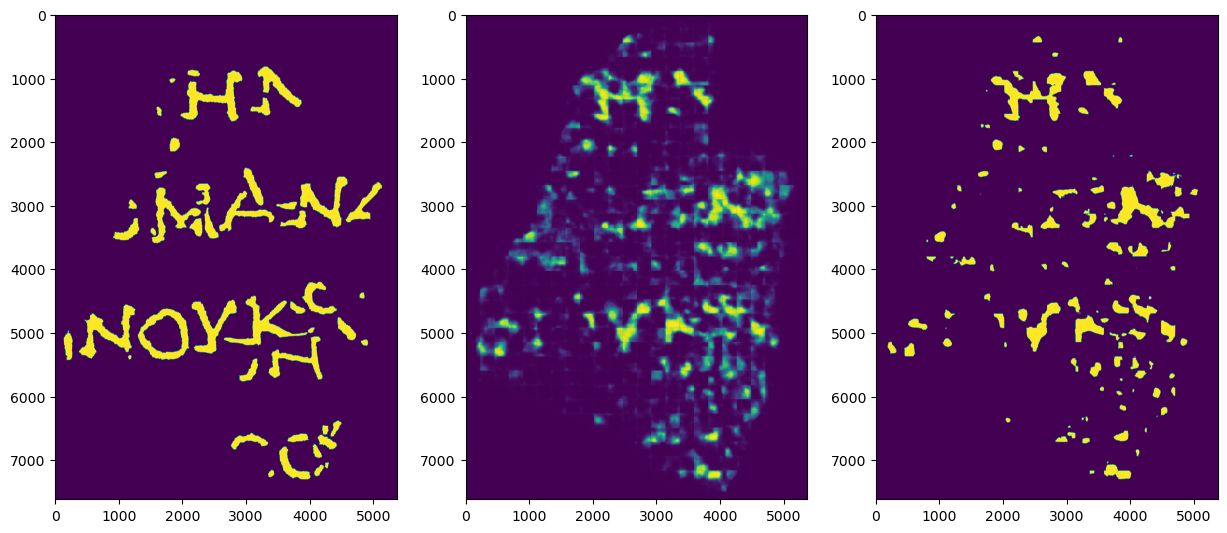

In [37]:
fig, axes = plt.subplots(1, 3, figsize=(15, 8))
axes[0].imshow(valid_mask_gt)
axes[1].imshow(mask_pred)
axes[2].imshow((mask_pred>=best_th).astype(int))

(array([32669655.,  2067816.,  1102594.,   747167.,   542212.,   442940.,
          374790.,   325364.,   300859.,   261673.,   234711.,   211063.,
          197080.,   183460.,   181067.,   188991.,   215610.,   250061.,
          276760.,   169743.]),
 array([1.06443524e-04, 4.98706093e-02, 9.96347751e-02, 1.49398941e-01,
        1.99163107e-01, 2.48927273e-01, 2.98691438e-01, 3.48455604e-01,
        3.98219770e-01, 4.47983936e-01, 4.97748102e-01, 5.47512267e-01,
        5.97276433e-01, 6.47040599e-01, 6.96804765e-01, 7.46568931e-01,
        7.96333096e-01, 8.46097262e-01, 8.95861428e-01, 9.45625594e-01,
        9.95389760e-01]),
 <BarContainer object of 20 artists>)

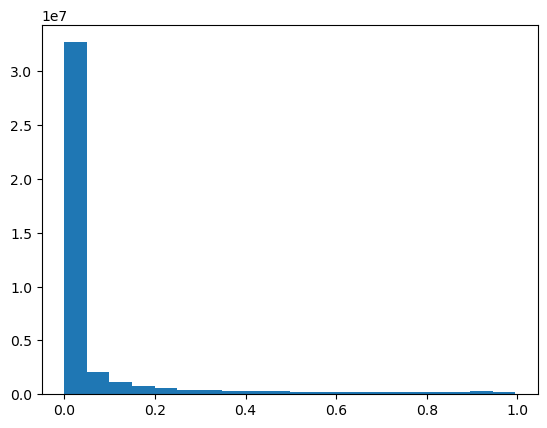

In [38]:
plt.hist(mask_pred.flatten(), bins=20)

In [39]:
# GPU VRAM 5.2GB/16.0GB A4000